In [51]:
import sys
import pandas as pd
import numpy as np
import datetime
import math
import operator
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import xgboost
import matplotlib.pyplot as plt


train_path = './data/train_v2.csv'
test_path = './data/test_v2.csv'
store_path = './data/store.csv'

dataset_path = './train/train_dataset.csv'
final_train_data = './train/train_dataset.csv'

model_dir = './model/'
save_path = './submission/submission.csv'

encoder_columns = [
                    'Assortment',
                    'StateHoliday',
                    'StoreType',
                    'Store',
                    'DayOfWeek',
                    'DayOfMonth'
                ]
scaler_columns = [
                    'StateHolidayDays',
                    'SchoolHolidayDays',
                    'PromoDays',
                    'Promo2DaysToNext',
                    'Promo2AllDays',
                    'Promo2Days',
                    'Customers',
                    'CompetitionDistance',
                    'CompetitionDays',
                    'Sales'
                ]

# Загрузка исходных данных


In [53]:
train_df = pd.read_csv(train_path, sep=',', index_col=False)
store_df = pd.read_csv(store_path, sep=',', index_col=False)
test_df = pd.read_csv(test_path, sep=',', index_col=False)

# Подготовка данных, расширение
Подготавливаем данные: объединяем исходные данные, дополняем собственными признаками

In [54]:
def monthToNum(month):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[month]

def prepare_data(train_df, store_df):
    train = []
    for i in range(1, 1116):
        day_after_close = 0
        promo_days = 0
        stateholiday_days = 0
        schoolholiday_days = 0
        data = train_df.loc[train_df['Store'] == i]
        info = store_df.loc[store_df['Store'] == i]       
        # Разбираемся с акциями Promo2 по конкретному магазину
        promo2_is_enabled = info.iloc[0]['Promo2'];
        promo2_months = []
        promo2_datetime = None
        if promo2_is_enabled == 1:
            buf = info.iloc[0]['PromoInterval'].split(',')
            promo2_months = np.array([monthToNum(x) for x in buf])
            promo2_datetime = datetime.datetime.strptime(f"{int(info.iloc[0]['Promo2SinceYear'])}-W{int(info.iloc[0]['Promo2SinceWeek'])}" + '-1', "%Y-W%W-%w")
        # Конкурент
        competition_datetime_enabled = 0
        if not math.isnan(info.iloc[0]['CompetitionOpenSinceYear']) or not math.isnan(info.iloc[0]['CompetitionOpenSinceMonth']):
            competition_datetime_enabled = 1
            competition_datetime = datetime.datetime(int(info.iloc[0]['CompetitionOpenSinceYear']), int(info.iloc[0]['CompetitionOpenSinceMonth']), 1)
        # Перебираем данные
        for j in reversed(range(0, data.shape[0])):
            # Текущая дата как datetime
            current_datetime = datetime.datetime.strptime(data.iloc[j]['Date'], "%Y-%M-%d")
            day_of_month = current_datetime.day
            store_is_open = data.iloc[j]['Open']
            if store_is_open == 1:
                # Праздники
                if data.iloc[j]['StateHoliday'] != '0':
                    stateholiday_days += 1
                else:
                    stateholiday_days = 0  
                # Каникулы
                if data.iloc[j]['SchoolHoliday'] != "0":
                    schoolholiday_days += 1
                else:
                    schoolholiday_days = 0
                # Все по Promo
                if data.iloc[j]['Promo'] == 1:
                    promo_days += 1
                else:
                    promo_days = 0
                # Все по Promo2
                promo2_is_active = 0
                promo2_days = 0           
                promo2_days_to_next = 0
                promo2_all_days = 0
                if promo2_is_enabled == 1:
                    promo2_all_days = (current_datetime - promo2_datetime).days
                    if current_datetime.month in promo2_months:
                        promo2_is_active = 1
                        promo2_days = day_of_month
                    else:
                        # Определяем ближайший месяц, когда начнется Promo2
                        promo2_starts = np.array([datetime.datetime(current_datetime.year, x, 1) for x in promo2_months])
                        buf = []
                        for date in promo2_starts:
                            if date > current_datetime:
                                buf.append((date - current_datetime).days)
                        days_to_next = np.min(buf)
                        if days_to_next < 15:
                            promo2_days_to_next = days_to_next
                # Количество дней со дня открытия конкурента
                competition_days = 0
                competition_distance = 0
                if competition_datetime_enabled == 1:
                    if current_datetime > competition_datetime:
                        competition_days = (current_datetime - competition_datetime).days 
                        competition_distance = info.iloc[0]['CompetitionDistance']
                # Все остальные данные "как есть"
                train.append(
                {
                    "Store": i,
                    "DayOfWeek": data.iloc[j]['DayOfWeek'],
                    "DayOfMonth": day_of_month,
                    "Open": store_is_open,
                    "Sales": data.iloc[j]['Sales'],
                    "Customers": data.iloc[j]['Customers'],
                    "Promo": data.iloc[j]['Promo'],
                    "PromoDays": promo_days,
                    "StateHoliday": str(data.iloc[j]['StateHoliday']),
                    "StateHolidayDays": stateholiday_days,
                    "SchoolHoliday": str(data.iloc[j]['SchoolHoliday']),
                    "SchoolHolidayDays": schoolholiday_days,
                    "StoreType": str(info.iloc[0]['StoreType']),
                    "Assortment": str(info.iloc[0]['Assortment']),
                    "CompetitionDistance": competition_distance,
                    "CompetitionDays": competition_days,
                    "Promo2": promo2_is_enabled,
                    "Promo2Active": promo2_is_active,
                    "Promo2Days": promo2_days,
                    "Promo2DaysToNext": promo2_days_to_next,
                    "Promo2AllDays": promo2_all_days,
                    "DayAfterClose": day_after_close
                })
                day_after_close = 0
            else:
                day_after_close = 1
    return pd.DataFrame.from_dict(train)

df = prepare_data(train_df, store_df)

# Анализ имеющихся данных
Ищем выбросы, зависимости и т.д.


       Store  Sales  Promo
556       11  17724      1
1166      24  19168      1
1172      24  18178      0
1173      24  18596      0
1328      27  19460      1
1329      27  18751      1
1729      35  20558      1
1744      35  17736      1
2046      42  19774      1
2047      42  17479      1
2401      49  17743      0
2764      57  20438      1
2770      57  18442      0
2771      57  17302      0
2896      60  20493      1
3111      64  20286      1
3114      64  18164      1
3117      64  19732      0
3118      64  19217      0
3311      68  17306      0
3364      69  17343      1
3378      69  17290      1
3384      69  20163      0
3486      71  18210      1
3988      82  19805      1
4084      84  21615      1
4088      84  20031      1
4096      84  23386      1
4097      84  21542      1
4098      84  19802      1
...      ...    ...    ...
54595   1114  19390      0
54596   1114  28117      0
54597   1114  29282      1
54598   1114  26988      1
54599   1114  25786      1
5

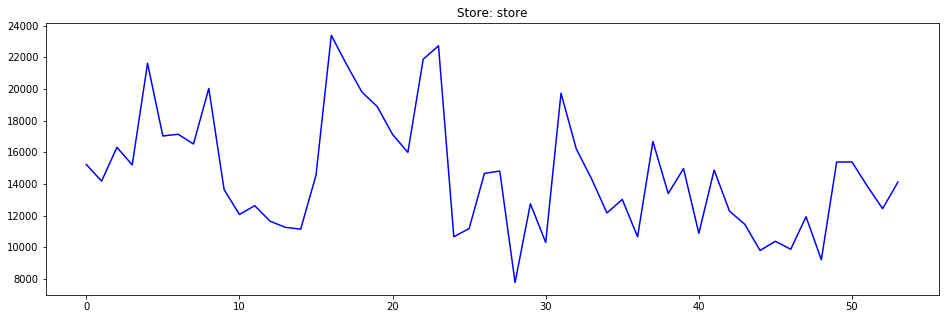

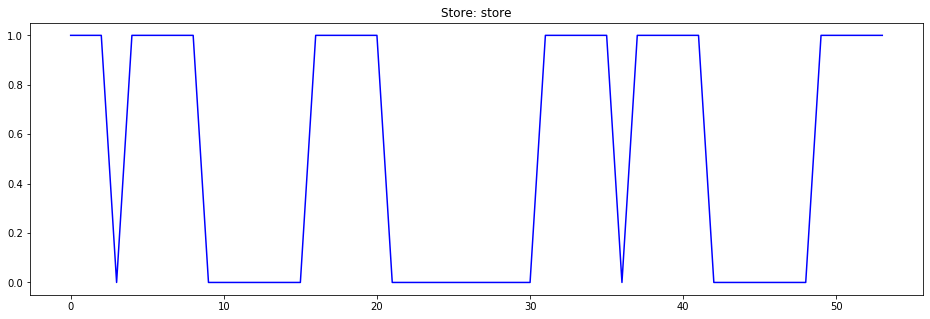

In [91]:
def visualisation(x, y, title):
    plt.figure(figsize=(16, 5))
    plt.plot(x, y, color='b')
    plt.title(title)
    plt.show()
    
def dataframe_analysis(df):
    q = df['Sales'].quantile(0.98)
    err = df[df['Sales'] > q]
    print(err[['Store', 'Sales', 'Promo']])
    
dataframe_analysis(df)
store = 84
sales = df[df['Store'] == store]
visualisation(range(0, sales.shape[0]), sales['Sales'].values, 'Store: store')
visualisation(range(0, sales.shape[0]), sales['Promo'].values, 'Store: store')

Необходимо вводить кластеризацию по объему продаж, под каждый кластер своя модель к уже имеющимся

# Собираем выборки для обучения и валидации


Создаем объекты MinMaxScaler для числовых признаков, OneHotEncoding - для категориальных признаков

In [55]:
def get_minmaxscaler(df, columns):
    scalers = []
    for column_name in columns:
        scaler = MinMaxScaler().fit(df[column_name].values.reshape(-1, 1))
        scalers.append((column_name, scaler))
    return scalers

def get_encoder(df, columns):
    encoders = []
    for column_name in columns:
        #if column_name == 'Store':
        #    objects = [x for x in range(1, 1116)]
        #else:
        #    objects = ['a', 'b', 'c', 'd', '0']
        objects = df[column_name].unique()
        label_enc = LabelEncoder()
        label_enc.fit(objects)
        labels = label_enc.transform(objects).reshape(-1, 1)
        onehot_enc = OneHotEncoder(sparse=False, categories='auto')
        onehot_enc.fit(labels)
        encoders.append((column_name, label_enc, onehot_enc))
    return encoders
        
def get_processing_objects(df, scaler_columns, encoder_columns):
    scalers = get_minmaxscaler(df, scaler_columns)
    encoders = get_encoder(df, encoder_columns)
    return scalers, encoders

scalers, encoders = get_processing_objects(df, scaler_columns, encoder_columns)

Получаем для дальнейшей работы обучающую и валидационную выборки

In [56]:
def get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns, split_train_test=True, ratio=0.9):
    x = pd.DataFrame()
    index = 0
    # Булевые (0/1) признаки - добавляем "как есть"
    columns = list(df.columns.values)
    for del_column in (scaler_columns + encoder_columns):
        columns.remove(del_column)
    for add_column in columns:
        # print(f'{add_column} - {index}')
        x[f'f{index}'] = df[add_column]
        index += 1
    # Категориальные признаки
    for enc in encoders:
        cat = enc[1].transform(df[enc[0]].values)
        labels = enc[2].transform(cat.reshape((-1, 1)))
        for i in range(0, labels.shape[1]):
            # print(f'{enc[0]} - {index}')
            x[f'f{index}'] = pd.Series(labels[:,i])
            index += 1
     # Числовые признаки
    for s in scalers:
        # print(f'{s[0]} - {index}')
        x[f'f{index}'] = s[1].transform([df[s[0]].values])[0]
        index += 1
    X = x.iloc[:, :-1]
    Y = x.iloc[:, -1]
    # Крайним оставляем таргет - 'Sales' - дабы после перехода с df на np.array не менять индексацию
    if split_train_test == True:
        # Делим на тестовую и обучающую выборки - Sales имеет индекс 2
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1-ratio, random_state=123)
        return x_train, x_test, y_train, y_test
    else:
        return X, Y

x_train, x_test, y_train, y_test = get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns)

Выявляем значимые признаки

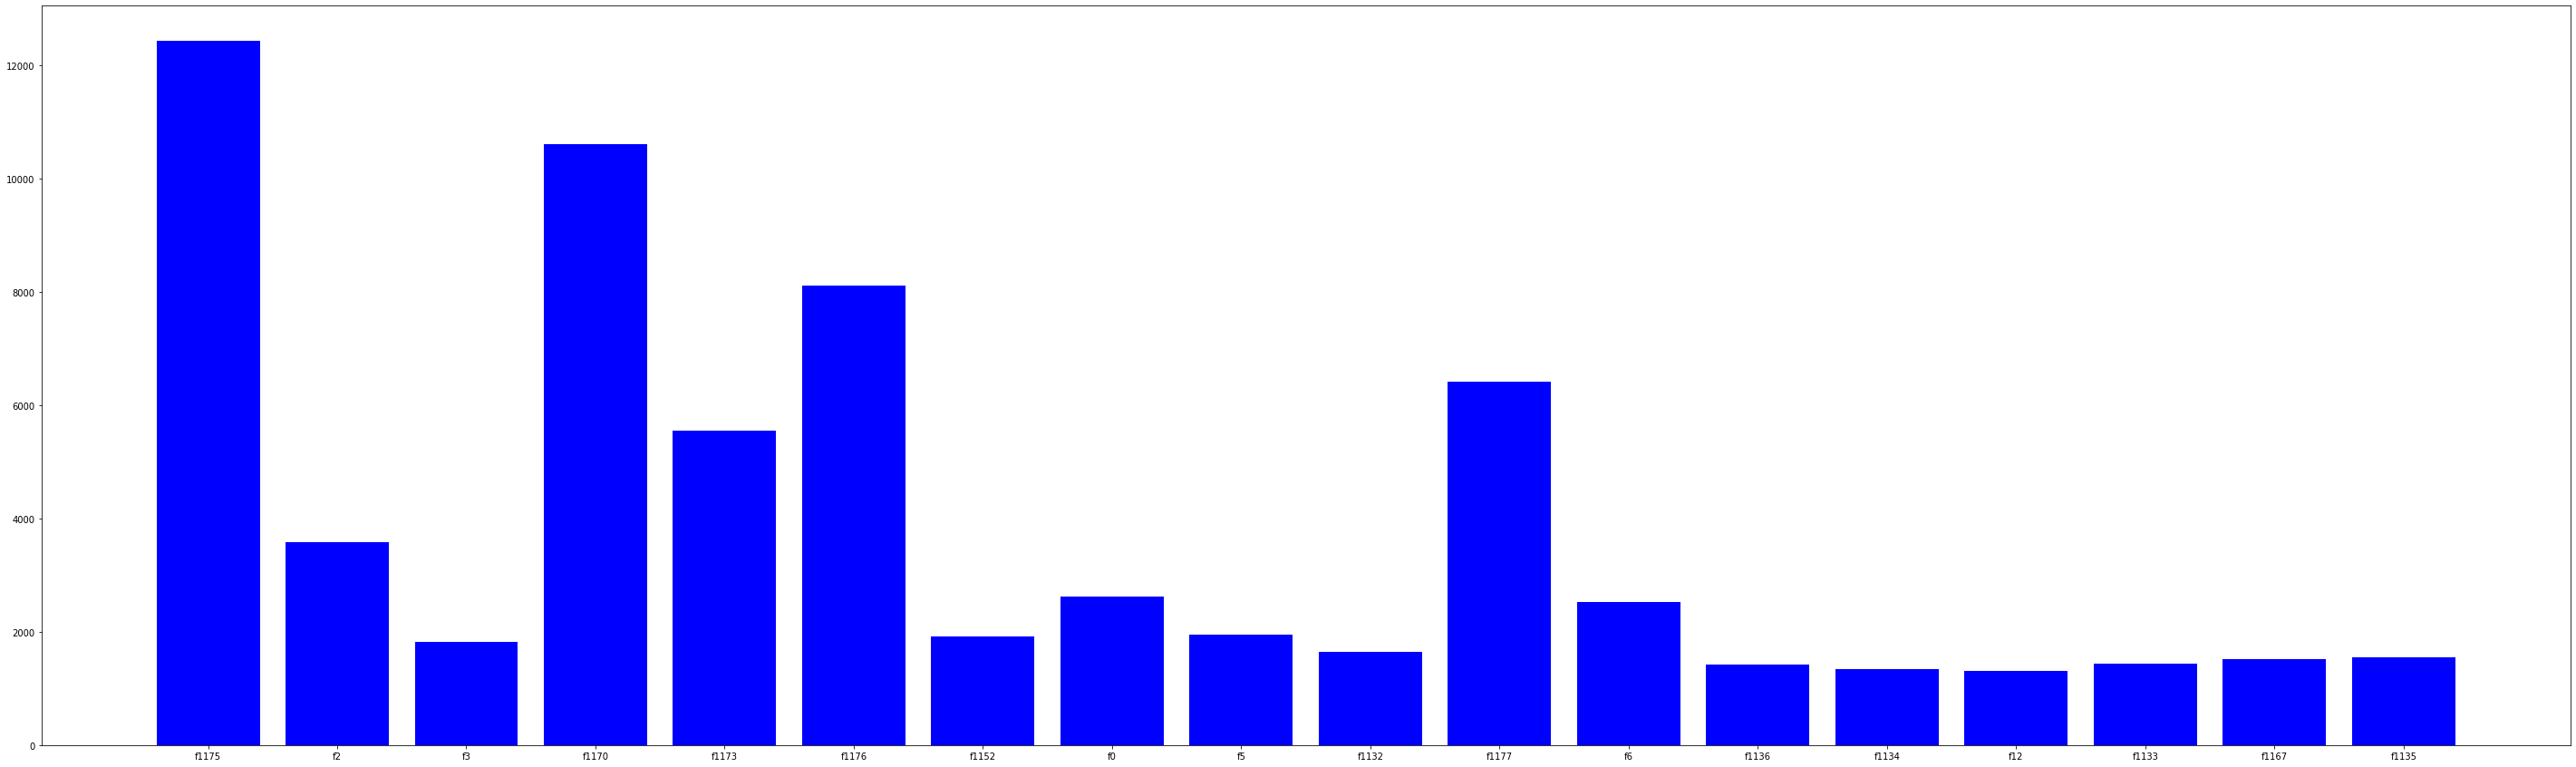

['f1175', 'f2', 'f3', 'f1170', 'f1173', 'f1176', 'f1152', 'f0', 'f5', 'f1132', 'f1177', 'f6', 'f1136', 'f1134', 'f12', 'f1133', 'f1167', 'f1135']


In [57]:
def get_feature_analyze_use_gb_model(x_train, y_train):
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', nrounds=1000, early_stopping_rounds=5, max_depth=12, n_estimators=320, subsample=0.9, learning_rate=0.02, seed=700)
    gbm.fit(x_train.values, y_train.values)
    imps = gbm.get_booster().get_fscore()
    _max = max(imps.items(), key=lambda k: k[1]) 
    _min = min(imps.items(), key=lambda k: k[1])
    # Берем признаки, у которых fscore не менее 5% от min...max вклада всех признаков
    threshold = (_max[1] - _min[1]) * 0.1 + _min[1]
    features = {k: v for (k, v) in imps.items() if v > threshold}
    # Отрисовываем гистограмму
    plt.figure(figsize=(50, 15))
    plt.bar(features.keys(), features.values(), color='b')
    plt.show()
    return list(features.keys())

print(get_feature_analyze_use_gb_model(x_train, y_train))

In [58]:
# fit_column = ['f1175', 'f2', 'f1170', 'f1173', 'f1176', 'f1152', 'f1132', 'f1135', 'f5', 'f1149', 'f1153', 'f1166', 'f1171', 'f1167', 'f1177', 'f1136', 'f1174', 'f1140', 'f1160', 'f1165', 'f1157', 'f1168', 'f1145', 'f1154', 'f0', 'f1164', 'f1159', 'f1133', 'f1161', 'f1146', 'f1134', 'f1156', 'f1143', 'f1150', 'f1147']
fit_column = ['f1175', 'f2', 'f3', 'f1170', 'f1173', 'f1176', 'f1152', 'f0', 'f5', 'f1132', 'f1177', 'f6', 'f1136', 'f1134', 'f12', 'f1133', 'f1167', 'f1135']

# Метрики

In [59]:
def rmspe(target, predict):
    return np.sqrt((((target - predict) / target) ** 2).mean())

# Обучение - xgboost
Будем использовать ансамбль моделей, первой будет xgboost
# Подбор параметров обучения
Подбираем параметры модели, фиксируем learning_rate на уровне 0.003, максимальную глубину ограничиваем на уровне 10ти, подбираем estimators, зависимость прямая, чем ниже learning_rate -> тем больше должен быть estimators

In [62]:
def get_xgb_model_fit_parameters(x_train, y_train, x_test, y_test, fit_column, scalers):
    stat = []
    scaler = scalers[-1]
    _y_train = scaler[1].inverse_transform([y_train.values])[0]
    _y_test = scaler[1].inverse_transform([y_test.values])[0]
    # for s in [700, 800]:
    s = 700
    for e in range(200, 501, 100):
        gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', nrounds=1000, early_stopping_rounds=10, max_depth=12, n_estimators=e, subsample=0.9, learning_rate=0.02, seed=s)
        gbm.fit(x_train[fit_column].values, y_train.values)
        # Тест: получаем предикт, проводим денормализацию, считаем ошибку
        y_train_pred = gbm.predict(x_train[fit_column].values)
        y_test_pred = gbm.predict(x_test[fit_column].values)
        _y_train_pred = scaler[1].inverse_transform(y_train_pred.reshape(1, -1))[0]
        _y_test_pred = scaler[1].inverse_transform(y_test_pred.reshape(1, -1))[0]
        stat.append({'rmspe_train': rmspe(_y_train, _y_train_pred), 'rmspe_test': rmspe(_y_test, _y_test_pred), 'estimators': e, 'seed': s})
    return pd.DataFrame.from_dict(stat)

stat = get_xgb_model_fit_parameters(x_train, y_train, x_test, y_test, fit_column, scalers)

Анализируем полученные результаты. Строим график зависимости rmspe(estimators)

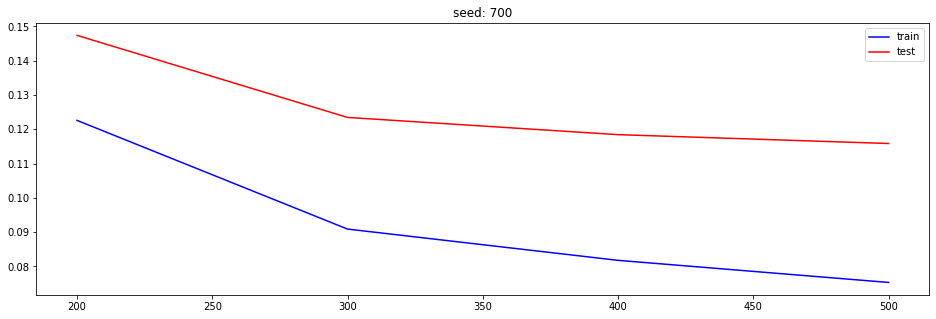

In [63]:
def visualisation_xgbmodel_fit(stat):
    seeds = stat['seed'].unique()
    for s in seeds:
        data = stat[stat['seed'] == s]
        plt.figure(figsize=(16, 5))
        plt.plot(data['estimators'], data['rmspe_train'], color='b', label='train')
        plt.plot(data['estimators'], data['rmspe_test'], color='r', label='test')
        plt.title(f'seed: {s}')
        plt.legend()
        plt.show()

visualisation_xgbmodel_fit(stat)

Из графика видно, что нам необходимо оставить значение estimator на уровне 300, далее до 1000 идет спад и снова подъем ошибки

# Обучение модели xgboost

In [64]:
def get_xgbmodel(x_train, y_train, x_test, y_test, fit_column, scalers):
    x = pd.concat([x_train, x_test])
    y = pd.concat([y_train, y_test])
    # gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=10, n_estimators=3000, subsample=1, learning_rate=0.003, seed=700)
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', nrounds=1000, early_stopping_rounds=5, max_depth=12, n_estimators=300, subsample=0.9, learning_rate=0.02, seed=700)
    gbm.fit(x[fit_column].values, y.values)
    return gbm

xgbmodel = get_xgbmodel(x_train, y_train, x_test, y_test, fit_column, scalers)
joblib.dump(xgbmodel, f'{model_dir}xgboost.bin')

['./model/xgboost.bin']

# Обучение линейной регрессии по всем магазинам
Используем линейную регрессию из модуля sklearn

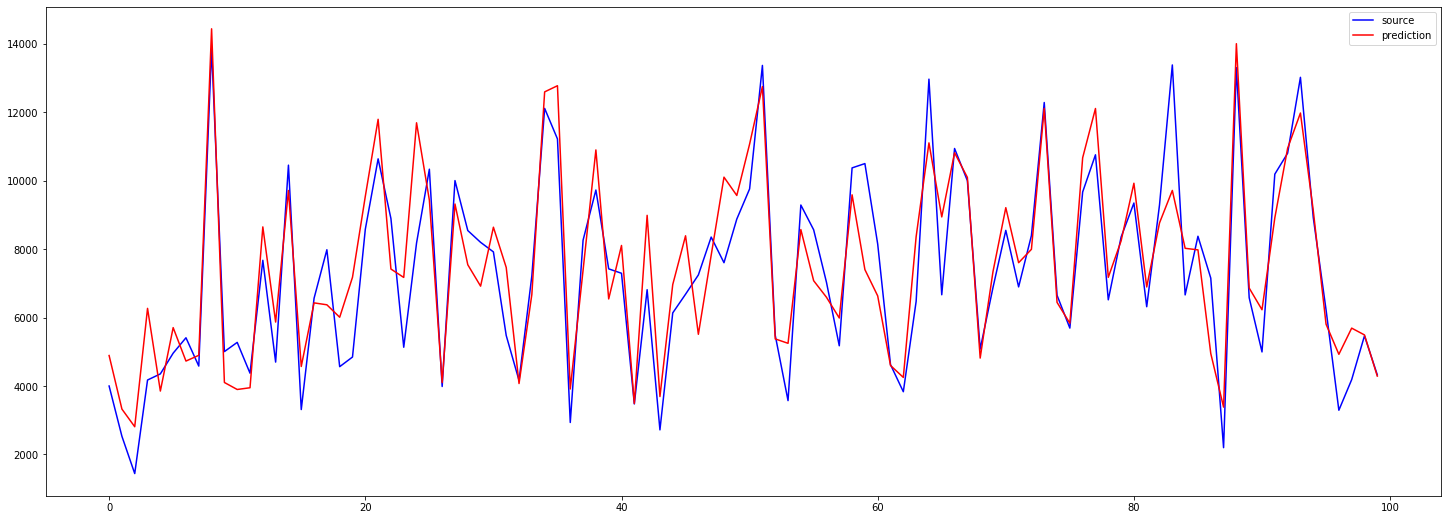

rmspe: 0.22130902500628835


['./model/lin_reg.bin']

In [92]:
def visualisation_linear_regression(y_test, y_pred):
    plt.figure(figsize=(25, 9))
    plt.plot(range(0, y_test.shape[0]), y_test, color='b', label='source')
    plt.plot(range(0, y_pred.shape[0]), y_pred, color='r', label='prediction')
    plt.legend()
    plt.show()

def get_linear_regression(x_train, y_train, x_test, y_test, fit_column, scalers):
    _x_train = x_train[fit_column].copy()
    _y_train = y_train.copy()
    _x_test = x_test[fit_column].copy()
    _y_test = y_test.copy()
    #lin_reg = LinearRegression(fit_intercept=False).fit(_x_train, _y_train)
    lin_reg = LinearRegression(fit_intercept=False).fit(_x_train, _y_train)
    y_pred = lin_reg.predict(_x_test)
    # Визуализируем
    _y_test = scalers[-1][1].inverse_transform([_y_test.values])[0]
    _y_pred = scalers[-1][1].inverse_transform(y_pred.reshape(1, -1))[0]
    visualisation_linear_regression(_y_test[:100],  _y_pred[:100])
    # Выводим величину ошибки
    print(f'rmspe: {rmspe(_y_test, _y_pred)}')
    return lin_reg
    
lr_model = get_linear_regression(x_train, y_train, x_test, y_test, fit_column, scalers)
joblib.dump(lr_model, f'{model_dir}lin_reg.bin')

# Кластеризация по продажам
Для повышения score в лидерборде с 0.73 необходимо опробовать кластеризацию, средние продажи по магазинам сильно разняться, надо поделить все магазины на кластеры, для каждого обучить свой буст, совместить с уже готовыми моделями и ансамблем использовать для получения конечного результата

# Обучаем финальную модель
Обучаем финальную, которая будет отталкиваться от результатов остальных

In [42]:
def get_final_model_fit_parameters(xgbmodel, lr_model, x_train, y_train, x_test, y_test, fit_column, scalers):
    _y_train = scalers[-1][1].inverse_transform([y_train.values])[0]
    _y_test = scalers[-1][1].inverse_transform([y_test.values])[0]
    # Данные для обучения
    y_train1 = xgbmodel.predict(x_train[fit_column].values)
    y_train2 = lr_model.predict(x_train[fit_column].values)
    _x_train = x_train[fit_column].copy()
    _x_train['y1'] = y_train1
    _x_train['y2'] = y_train2
    # Данные для тестов
    y_test1 = xgbmodel.predict(x_test[fit_column].values)
    y_test2 = lr_model.predict(x_test[fit_column].values)
    _x_test = x_test[fit_column].copy()
    _x_test['y1'] = y_test1
    _x_test['y2'] = y_test2
    # Подбираем параметры
    stat = []
    for e in range(100, 1001, 250):
        gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', nrounds=1000, early_stopping_rounds=5, max_depth=12, n_estimators=e, subsample=0.9, learning_rate=0.02, seed=700)
        gbm.fit(_x_train.values, y_train.values)
        # Тест
        y_train_pred = gbm.predict(_x_train.values)
        _y_train_pred = scalers[-1][1].inverse_transform(y_train_pred.reshape(1, -1))[0]
        y_test_pred = gbm.predict(_x_test.values)
        _y_test_pred = scalers[-1][1].inverse_transform(y_test_pred.reshape(1, -1))[0]
        stat.append({'rmspe_train': rmspe(_y_train, _y_train_pred), 'rmspe_test': rmspe(_y_test, _y_test_pred), 'estimators': e, 'seed': 700})
    return pd.DataFrame.from_dict(stat)

lr_model = joblib.load(f'{model_dir}lin_reg.bin')
xgbmodel = joblib.load(f'{model_dir}xgboost.bin')
final_stat = get_final_model_fit_parameters(xgbmodel, lr_model, x_train, y_train, x_test, y_test, fit_column, scalers)
visualisation_xgbmodel_fit(final_stat)

KeyboardInterrupt: 

Обучаем


In [69]:
def get_final_xgbmodel(xgbmodel, lr_model, x_train, y_train, x_test, y_test, fit_column, scalers):
    x = pd.concat([x_train, x_test])
    y = pd.concat([y_train, y_test])
    # Данные для обучения
    y1 = xgbmodel.predict(x[fit_column].values)
    y2 = lr_model.predict(x[fit_column].values)
    x = x[fit_column]
    x['y1'] = y1
    x['y2'] = y2
    # gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=10, n_estimators=3000, subsample=1, learning_rate=0.003, seed=700)
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', nrounds=1000, early_stopping_rounds=5, max_depth=12, n_estimators=320, subsample=0.9, learning_rate=0.02, seed=700)
    gbm.fit(x.values, y.values)
    return gbm

xgb_model_final = get_final_xgbmodel(xgbmodel, lr_model, x_train, y_train, x_test, y_test, fit_column, scalers)
joblib.dump(xgb_model_final, f'{model_dir}xgboost_final.bin')

['./model/xgboost_final.bin']

# Генерируем сабмишн
Загружаем тестовый датасет, рассчитываем свои дополнительные признаки, формируем сабмишн

In [70]:
def generate_submission(df, xgbmodel_final, xgbmodel, lr_model, fit_column, scalers, save_path):
    # Добавляем пустой столбец 'Sales', чтобы использовать метод prepare_data
    test_df['Sales'] = np.zeros(test_df.shape[0])
    df = prepare_data(test_df, store_df)
    x, y = get_train_and_test_datasets(df, scalers, scaler_columns, encoders, encoder_columns, split_train_test=False)
    # Получаем предикт от первой модели xgboost
    y_pred1 = xgbmodel.predict(x[fit_column].values)
    # Получаем предикт от линейной регрессии
    y_pred2 = lr_model.predict(x[fit_column].values)
    # Добавляем предикты в датасет
    x = x[fit_column]
    x['y1'] = y_pred1
    x['y2'] = y_pred2
    # Рассчитываем основной моделью (финальной)
    y_pred = xgbmodel_final.predict(x.values)
    y_pred_dec = scalers[-1][1].inverse_transform(y_pred.reshape(1, -1))[0] * 0.9
    # Полученная выборка не содержит дней, когда магазин не работал, необходимо заполнить эти дни нулями
    result = pd.DataFrame()
    index = 0
    store = []
    sales = []
    for i in range(0, test_df.shape[0]):
        store.append(i + 1)
        if test_df.iloc[i]['Open'] == 1:
            sales.append(y_pred_dec[index])
            index += 1
        else:
            sales.append(1)
            #sales.append(0)
    result = pd.DataFrame({'Id': store, 'Sales': sales})
    result.to_csv(save_path, index=False, sep=',')
    
generate_submission(test_df, xgb_model_final, xgbmodel, lr_model, fit_column, scalers, save_path)